<a href="https://colab.research.google.com/github/asifimtiaz93/Thesis/blob/main/DDos_VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# prompt: mount drive

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np

# Define the dataset path
data_path = '/content/drive/MyDrive/Thesis/Dataset/DoS_dataset.csv'

# Define column names
columns = ['timestamp', 'CAN_ID', 'DLC', 'Payload[0]', 'Payload[1]', 'Payload[2]',
           'Payload[3]', 'Payload[4]', 'Payload[5]', 'Payload[6]', 'Payload[7]', 'Classification']

# Load the dataset with sampling to reduce memory usage
sample_fraction = 0.001  # Adjust this fraction as needed
df = pd.read_csv(data_path, names=columns).sample(frac=sample_fraction, random_state=42)

# Display the sampled dataset shape and first few rows
print(f"Sampled Dataset Shape: {df.shape}")
print("Sampled Dataset:")
print(df.head())

# Preprocessing steps:

# 1. Compute timestamp differences
df['timestamp_diff'] = df['timestamp'].diff().fillna(0)

# 2. Convert CAN_ID to an integer feature
def hex_to_integer(hex_str):
    # Convert hex string to integer
    try:
        return int(hex_str, 16)
    except ValueError:
        return 0  # Handle invalid values gracefully

# Apply the conversion to CAN_ID column
df['CAN_ID_integer'] = df['CAN_ID'].apply(hex_to_integer)

# 3. Convert Payload bytes to a single integer feature
def payload_to_integer(payload_values):
    binary_values = []
    for val in payload_values:
        try:
            # Convert each payload value to a binary string and append
            binary_values.append(f"{int(str(val), 16):08b}")
        except ValueError:
            binary_values.append('00000000')  # Default for invalid values
    # Join binary values and convert the entire payload to an integer
    return int(''.join(binary_values), 2)

# Apply the conversion to Payload columns
payload_columns = [f'Payload[{i}]' for i in range(8)]
df['Payload_integer'] = df[payload_columns].apply(lambda row: payload_to_integer(row), axis=1)

# 4. Map Classification to 0 (Normal) and 1 (Threat)
df['Classification'] = df['Classification'].map({'R': 0, 'T': 1})

# 5. Drop unnecessary columns (CAN_ID, timestamp, individual payload columns)
df.drop(columns=['CAN_ID', 'timestamp'] + payload_columns, inplace=True)

# Display the processed dataset shape and first few rows
print(f"Processed Dataset Shape: {df.shape}")
print("Processed Dataset:")
print(df.head())

# Save the preprocessed dataset to a new file
preprocessed_path = '/content/drive/MyDrive/Thesis/Dataset/DoS_dataset_preprocessed.csv'
df.to_csv(preprocessed_path, index=False)
print(f"Preprocessed dataset saved to: {preprocessed_path}")


Sampled Dataset Shape: (3666, 12)
Sampled Dataset:
            timestamp CAN_ID  DLC Payload[0] Payload[1] Payload[2] Payload[3]  \
2771604  1.478201e+09   02c0    8         14         00         00         00   
2858691  1.478201e+09   0131    8         00         80         00         00   
2578057  1.478201e+09   0316    8         05         23         30         0a   
2269155  1.478200e+09   0260    8         1a         23         23         30   
2965992  1.478201e+09   0440    8         ff         00         00         00   

        Payload[4] Payload[5] Payload[6] Payload[7] Classification  
2771604         00         00         00         00              R  
2858691         25         7f         09         6e              R  
2578057         23         1f         00         6f              R  
2269155         08         8e         6d         03              R  
2965992         ff         dc         08         00              R  
Processed Dataset Shape: (3666, 5)
Processed Dat

In [4]:
# prompt: download csv

from google.colab import files
files.download('/content/drive/MyDrive/Thesis/Dataset/DoS_dataset_preprocessed.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [11]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Lambda, Layer
from tensorflow.keras.models import Model
from tensorflow.keras.losses import mse
import tensorflow.keras.backend as K

# Load the preprocessed dataset
data_path = '/content/drive/MyDrive/Thesis/Dataset/DoS_dataset_preprocessed.csv'
df = pd.read_csv(data_path)

# Extract features and normalize
features = df[['DLC', 'timestamp_diff', 'CAN_ID_integer', 'Payload_integer']].values
labels = df['Classification'].values  # Not used in VAE training but useful for evaluation

# Normalize the features (scale to range [0, 1])
features = features / np.max(features, axis=0)

# Define latent space dimension
latent_dim = 2  # You can adjust this based on your needs

# VAE Encoder
input_dim = features.shape[1]
inputs = Input(shape=(input_dim,))
h = Dense(128, activation='relu')(inputs)
h = Dense(64, activation='relu')(h)
z_mean = Dense(latent_dim, name='z_mean')(h)
z_log_var = Dense(latent_dim, name='z_log_var')(h)

# Sampling layer
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# VAE Decoder
decoder_h = Dense(64, activation='relu')
decoder_h2 = Dense(128, activation='relu')
decoder_mean = Dense(input_dim, activation='sigmoid')
h_decoded = decoder_h(z)
h_decoded = decoder_h2(h_decoded)
outputs = decoder_mean(h_decoded)

# Define the VAE model
vae = Model(inputs, outputs, name='vae')

# Loss function
# Loss function
# Reconstruction loss (using mean squared error)
from keras.layers import Layer

class VAELossLayer(Layer):
    def __init__(self, **kwargs):
        super(VAELossLayer, self).__init__(**kwargs)

    def call(self, inputs):
        original, reconstructed, z_mean, z_log_var = inputs

        # Reconstruction loss
        reconstruction_loss = K.sum(K.square(original - reconstructed), axis=-1)

        # KL divergence loss
        kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)

        # Total loss
        total_loss = reconstruction_loss + kl_loss

        # Add the loss to the model
        self.add_loss(K.mean(total_loss))
        return reconstructed

# Modify the decoder output to pass through the loss layer
vae_outputs = VAELossLayer()([inputs, outputs, z_mean, z_log_var])
vae = Model(inputs, vae_outputs)
vae.compile(optimizer='adam')




# Train the VAE
vae.fit(features, features,
        epochs=50,
        batch_size=128,
        shuffle=True,
        validation_split=0.2)

# Save the encoder and decoder for future use
encoder = Model(inputs, z_mean, name='encoder')
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_h_decoded = decoder_h2(_h_decoded)
_output_decoded = decoder_mean(_h_decoded)
decoder = Model(decoder_input, _output_decoded, name='decoder')

print("VAE training complete.")


Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.8884 - val_loss: 0.5923
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5292 - val_loss: 0.4268
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4132 - val_loss: 0.3977
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3850 - val_loss: 0.3855
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3837 - val_loss: 0.3848
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3808 - val_loss: 0.3821
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3922 - val_loss: 0.3817
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3827 - val_loss: 0.3815
Epoch 9/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3819 - val_loss: 0.3815
Epoch 10/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3726 - val_loss: 0.3795
Epoch 11/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3764 - val_loss: 0.3788
Epoch 12/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3767 - val_

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


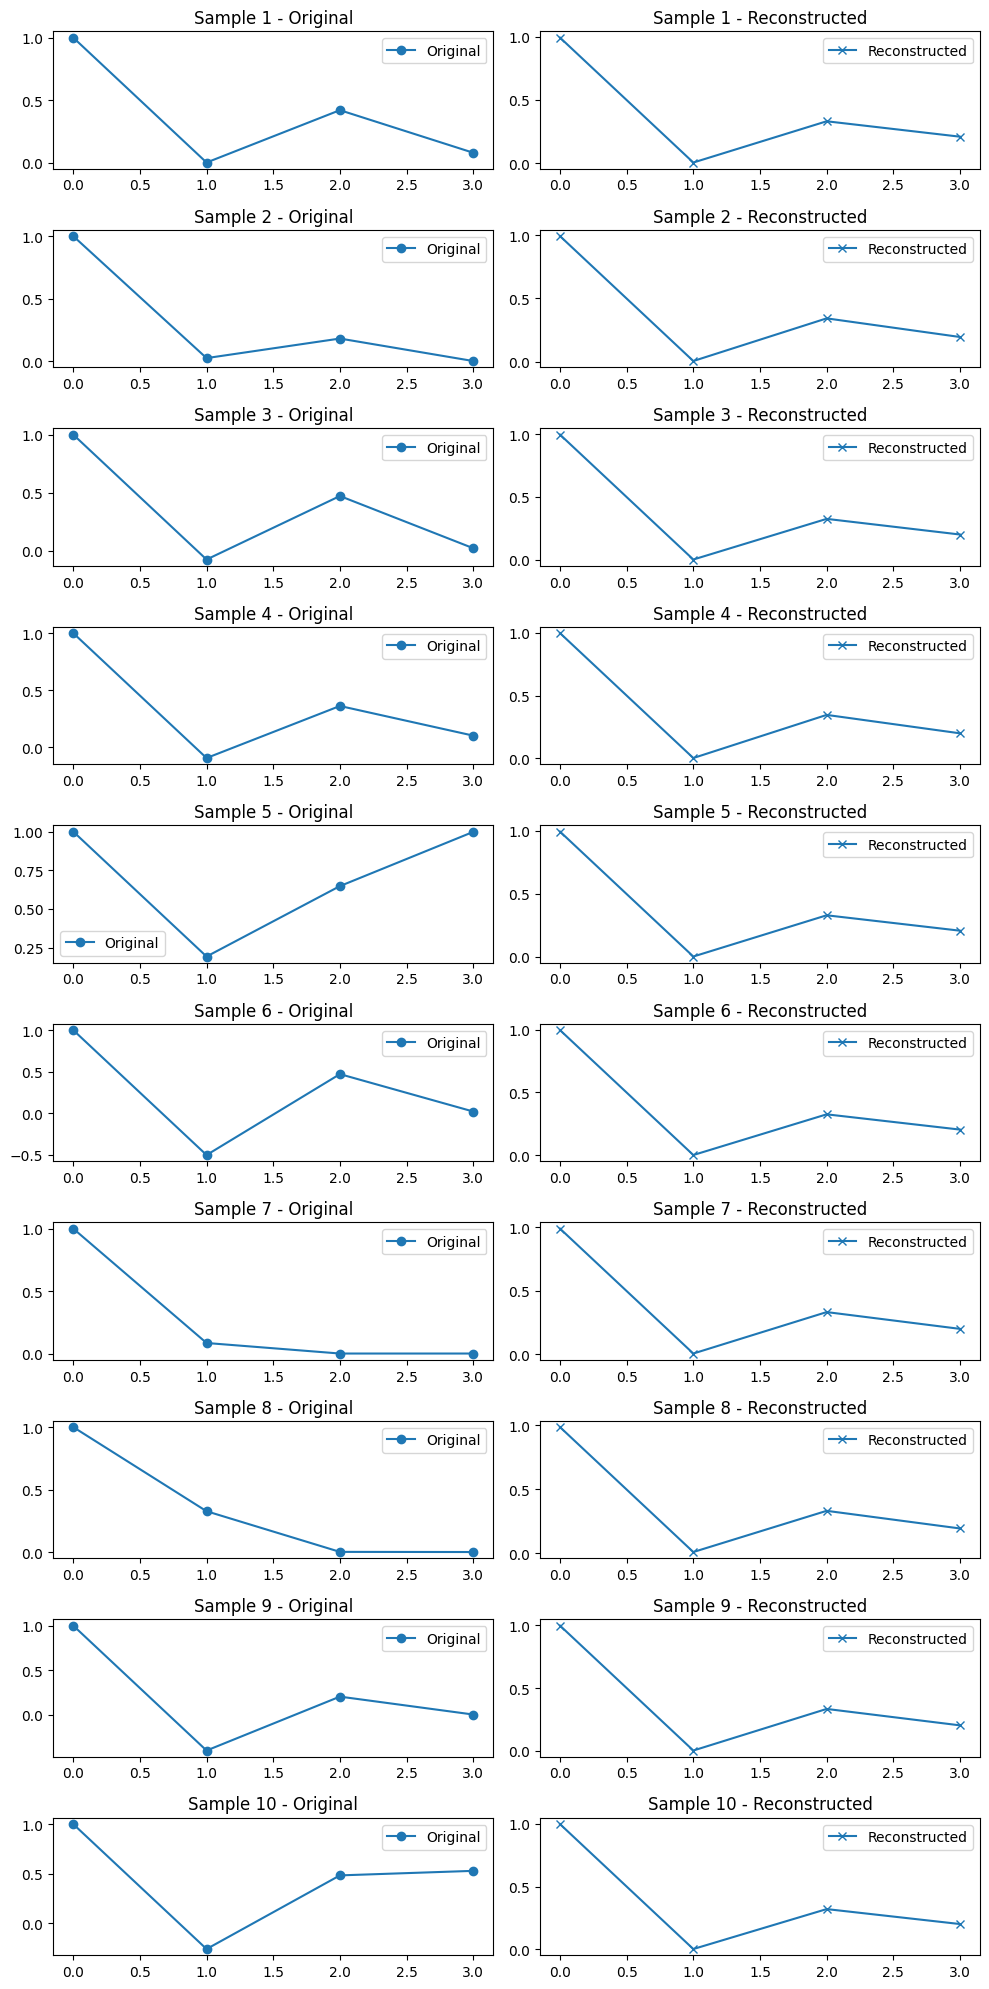

In [12]:
# Reconstruct the input data
reconstructed_features = vae.predict(features)

# Visualize the original and reconstructed features for comparison
import matplotlib.pyplot as plt

n_samples = 10  # Number of samples to visualize
fig, axes = plt.subplots(n_samples, 2, figsize=(10, 2 * n_samples))
for i in range(n_samples):
    # Original features
    axes[i, 0].plot(features[i], label="Original", marker="o")
    axes[i, 0].set_title(f"Sample {i+1} - Original")
    axes[i, 0].legend()

    # Reconstructed features
    axes[i, 1].plot(reconstructed_features[i], label="Reconstructed", marker="x")
    axes[i, 1].set_title(f"Sample {i+1} - Reconstructed")
    axes[i, 1].legend()

plt.tight_layout()
plt.show()


115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


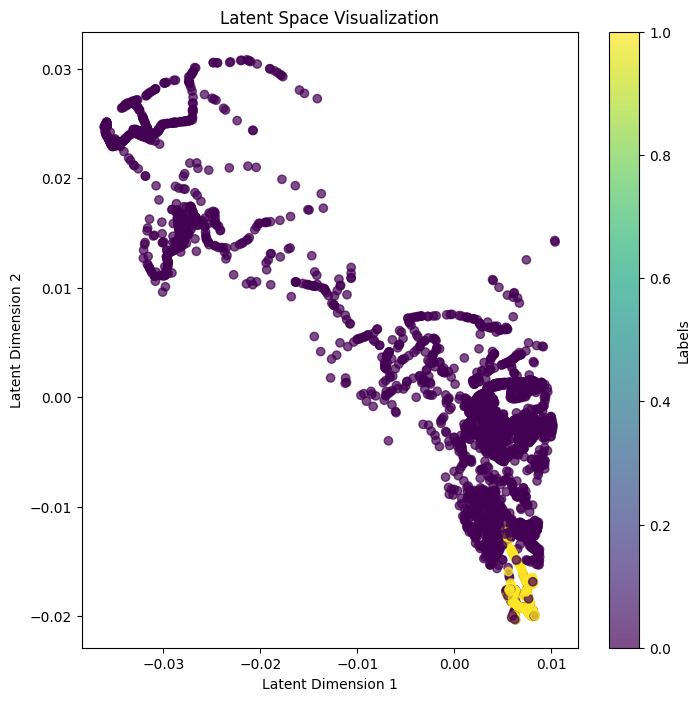

In [13]:
# Project the dataset into the latent space
latent_space = encoder.predict(features)

# Scatter plot of latent space
plt.figure(figsize=(8, 8))
plt.scatter(latent_space[:, 0], latent_space[:, 1], c=labels, cmap="viridis", alpha=0.7)
plt.colorbar(label="Labels")
plt.xlabel("Latent Dimension 1")
plt.ylabel("Latent Dimension 2")
plt.title("Latent Space Visualization")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Generated samples:
[[9.9968773e-01 2.2159485e-04 3.1436336e-01 1.5447816e-01]
 [9.8926961e-01 8.3574792e-03 3.3779377e-01 1.9739462e-01]
 [9.8830140e-01 9.7788274e-03 3.3152074e-01 1.9133100e-01]
 [9.9977571e-01 1.0570865e-04 3.1180409e-01 1.9666290e-01]
 [9.9195182e-01 6.2487312e-03 3.3250284e-01 2.0116630e-01]
 [9.9047273e-01 8.2318364e-03 3.3215371e-01 1.9152710e-01]
 [9.9293393e-01 5.1081688e-03 3.3050185e-01 2.0697181e-01]
 [9.9811614e-01 1.3271587e-03 3.1960899e-01 1.8309659e-01]
 [9.9691409e-01 2.3008734e-03 3.3661714e-01 1.8549971e-01]
 [9.9673897e-01 2.3730465e-03 3.3822742e-01 1.8709312e-01]]


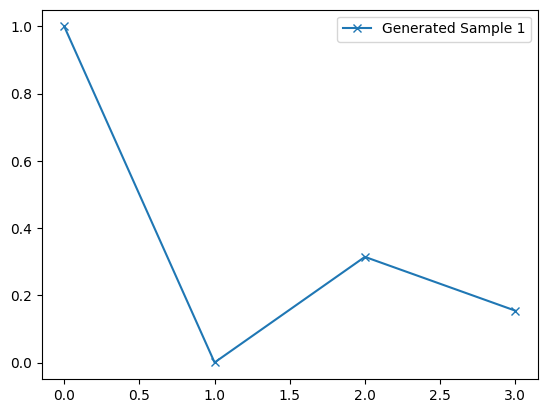

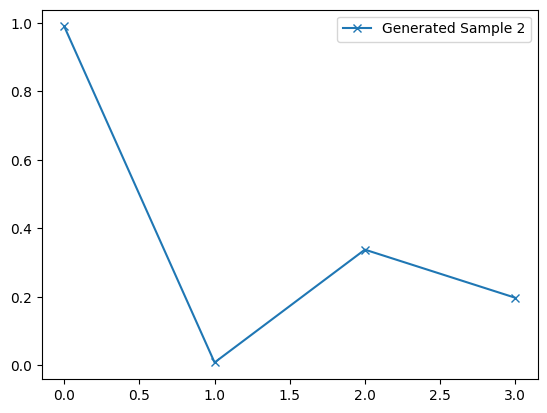

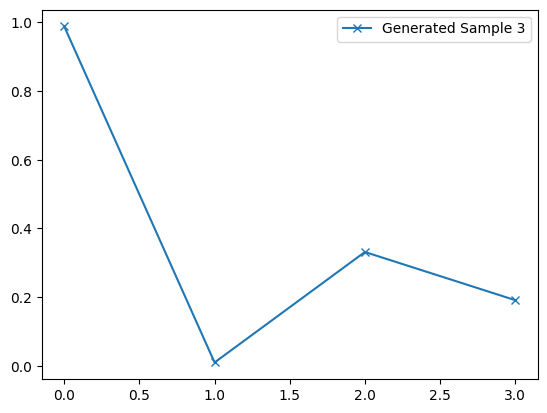

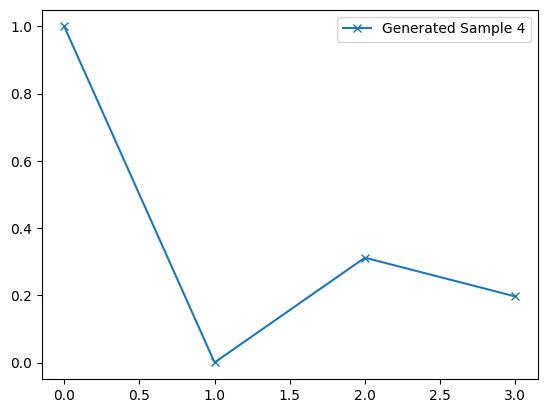

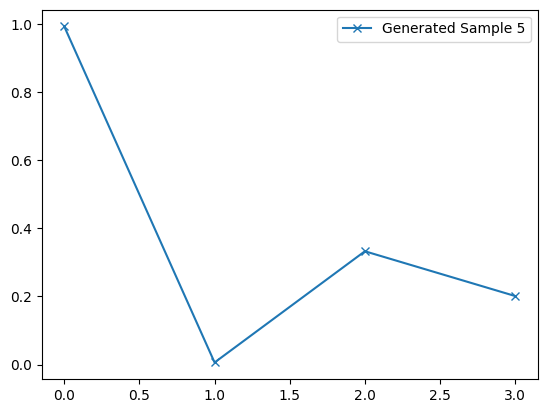

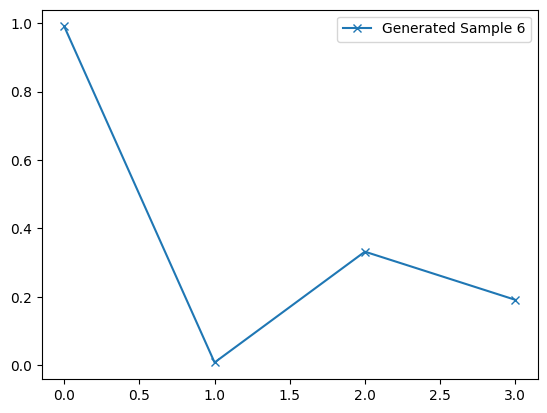

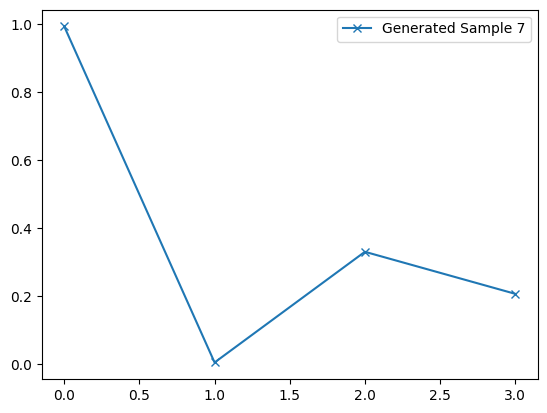

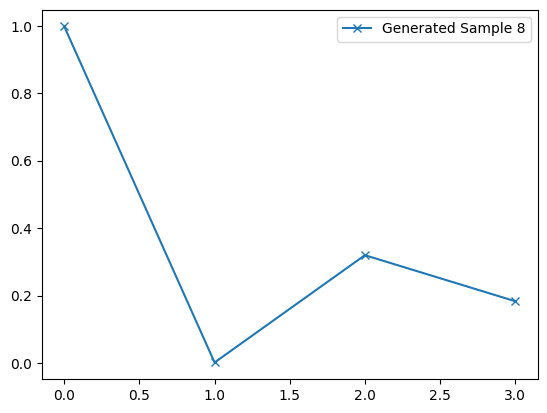

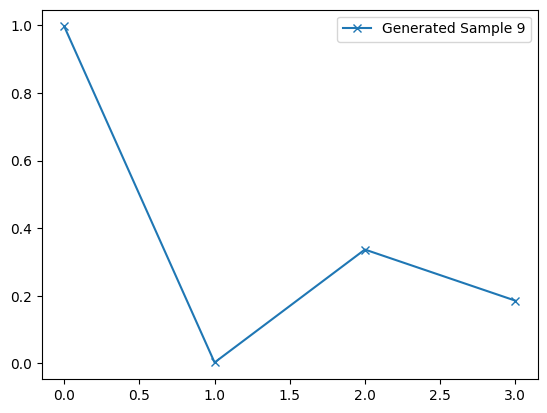

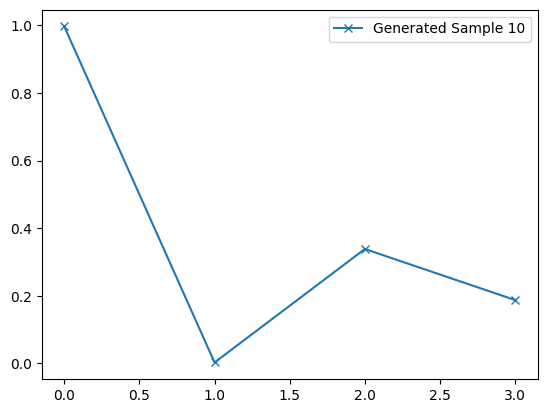

In [14]:
# Generate random latent vectors
random_latent_vectors = np.random.normal(size=(10, latent_dim))

# Generate new samples
generated_samples = decoder.predict(random_latent_vectors)

# Visualize the generated samples
print("Generated samples:")
print(generated_samples)

# If the data is visualizable (e.g., images or similar features), plot the samples:
for i, sample in enumerate(generated_samples):
    plt.figure()
    plt.plot(sample, marker="x", label=f"Generated Sample {i+1}")
    plt.legend()
    plt.show()


In [15]:
from sklearn.metrics import mean_squared_error

# Calculate reconstruction loss
train_loss = mean_squared_error(features, reconstructed_features)
print(f"Reconstruction MSE (training data): {train_loss:.4f}")


Reconstruction MSE (training data): 0.0946
